In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import scipy.optimize as op
from datetime import datetime

import os
from pandas.tseries.offsets import BDay

## a) Loading the return series

In [2]:
ret_file = os.path.join('MFE_DAM', 'Data', 'US.csv')
us_ret = pd.read_csv(ret_file, parse_dates=[0], index_col=[0], na_values=[0])
us_ret = us_ret.fillna(method='ffill')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002005BDC0A90>,
      dtype=object)

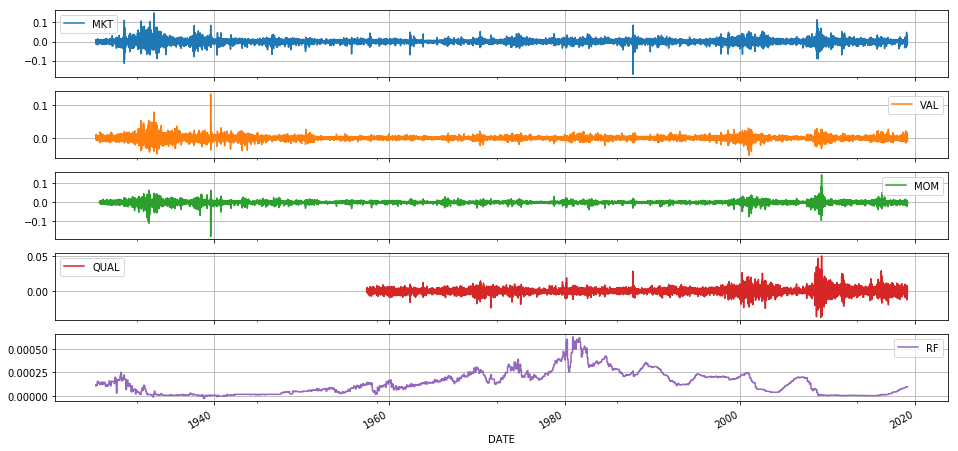

In [3]:
us_ret.plot(figsize=(16,8), grid=True, subplots=True)

In [4]:
us_Price = (us_ret+1).cumprod().shift(1)
for col in us_Price.columns:
    lastNanRow = max(np.where(us_Price[col].isnull())[0])
    us_Price.loc[us_Price.index[lastNanRow],col] = 1
us_Price

,MKT,VAL,MOM,QUAL,RF
DATE,,,,,
1926-07-31,1.000000,1.000000,NaN,NaN,1.000000
1926-08-02,1.004327,1.000119,NaN,NaN,1.000106
1926-08-03,1.012653,1.001592,NaN,NaN,1.000226
1926-08-04,1.017484,0.999310,NaN,NaN,1.000346
1926-08-05,1.013819,1.000493,NaN,NaN,1.000466
1926-08-06,1.012916,1.007472,NaN,NaN,1.000586
1926-08-07,1.019714,1.009039,NaN,NaN,1.000706
1926-08-09,1.024276,1.007618,NaN,NaN,1.000826
1926-08-10,1.026235,1.006002,NaN,NaN,1.000946


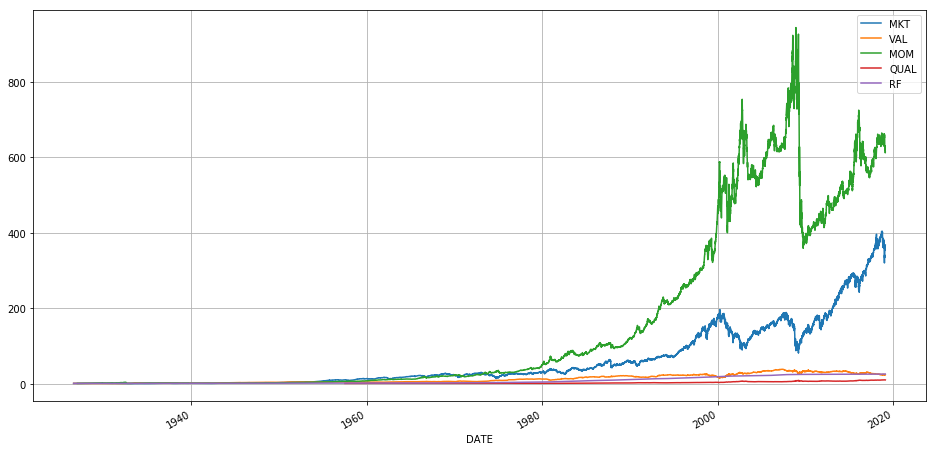

In [5]:
us_Price.plot(figsize=(16,8), grid=True, subplots=False)

## b) Functions definition

In [6]:
def adjustWeights(weights, df_Price):
    weights_adj = weights.copy()
    df_Price = df_Price.reindex(columns=weights.columns)
    
    mask, _ = df_Price.align(weights_adj, join='right', axis=0)
    weights_adj[mask.isnull()] = 0
    weights_adj['RF'] = 1-weights_adj.sum(axis = 1, skipna = True)
    return weights_adj

In [7]:
def convertWeights2Shares(weights, df_Price, GMV, Tcost_vec):
    """
    Tcost considered
    """
    turnover = 0
    shares = pd.DataFrame(columns = weights.columns, index = weights.index)
    idx = weights.index
    asset_Price = df_Price.reindex(columns=weights.columns)

    shares.loc[idx[0],:] = GMV*weights.loc[idx[0],:]/asset_Price.loc[idx[0],:]
    for i in range(1,len(idx)):
        if abs(weights.loc[idx[i],:].sum()) < 1e-10:
            shares.loc[idx[i],:] = shares.loc[idx[i-1],:]
        else:
            val_wo_rebalance = shares.loc[idx[i-1],:]*asset_Price.loc[idx[i],:]
            GMV_wo_rebalance = val_wo_rebalance.sum()
            val_before_Tcost = GMV_wo_rebalance*weights.loc[idx[i],:]
            val_abs_diff = val_before_Tcost.subtract(val_wo_rebalance, fill_value=0).abs()
            cost = (val_abs_diff*Tcost_vec).sum()
            val_after_Tcost = (GMV_wo_rebalance-cost)*weights.loc[idx[i],:]
            shares.loc[idx[i],:] = val_after_Tcost/asset_Price.loc[idx[i],:]
            turnover += cost
    return (shares, turnover)

In [8]:
def df2Daily(df, idx):
    """
    Change the weights frequency into daily basis
    Forward fill the inbetween elements
    """
    df_daily = pd.DataFrame(index = idx)
    for col in df.columns:
        df_daily[col] = df[col]
    df_daily.fillna(method='ffill',inplace=True)
    return df_daily

In [9]:
def calcPnl(df_Price, shares_daily):
    price_reindexed = df_Price.reindex(columns=shares_daily.columns)
    pnl = shares_daily*price_reindexed.values
    nonNanRow = min(np.where((~pnl.isnull()).any(axis=1))[0])
    pnl = pnl.sum(axis=1)
    pnl.iloc[:nonNanRow] = np.nan
    pnl = pnl/pnl[nonNanRow]-1
    pnl.dropna(inplace=True)
    return (pnl, nonNanRow)

In [10]:
def cumul_perf(ret):
    """
    Function to calculate the cumulative excess return series
    """
    return ((1 + ret).cumprod(axis=0)) - 1

In [11]:
def SR(pnl):
    pnl_diff = pnl.diff()
    pnl_diff.dropna(inplace=True)
    rsl = np.sqrt(252)*pnl_diff.mean()/pnl_diff.std(ddof=0)
    return rsl

In [12]:
def maxDrawDown(pnl):
    T = pnl.iloc[0]
    Vmin = pnl.iloc[0]
    Tmax = max(0.,T)
    for i in range(1,len(pnl)):
        T = pnl.iloc[i]
        if T-Tmax < Vmin:
            Vmin = T-Tmax
        if T>Tmax:
            Tmax = T
    return Vmin

## c) Parameter Configuration

In [13]:
day_lag = 1
GMV = 1e6
Tcost_vec = np.array([10e-4,120e-4,275e-4,120e-4, 0])

## d) Testing weights

In [14]:
testingFile = os.path.join('MFE_DAM', 'test_weights.csv')
weights = pd.read_csv(testingFile, parse_dates=[0], index_col=[0])
weights.index = weights.index + BDay(day_lag)
weights['RF'] = 0.

In [15]:
weights.drop(weights.loc[:'1926-7-31'].index, axis=0, inplace=True)

In [16]:
weights.loc[weights.isnull().any(axis=1)]

,MKT,VAL,MOM,QUAL,RF
Date,,,,,


In [17]:
weights = adjustWeights(weights, us_Price)
(shares, turnover) = convertWeights2Shares(weights, us_Price, GMV, Tcost_vec)
shares_daily = df2Daily(shares, us_Price.index)
shares

,MKT,VAL,MOM,QUAL,RF
Date,,,,,
1926-08-02,658592,112839,NaN,NaN,225682
1926-09-01,620828,121474,NaN,NaN,255243
1926-10-01,609050,125867,NaN,NaN,262690
1926-11-01,632833,117736,NaN,NaN,247565
1926-12-01,617264,123012,NaN,NaN,257677
1927-01-03,589323,130260,139870,NaN,137465
1927-02-01,586342,128122,140923,NaN,141771
1927-03-01,556558,135614,153147,NaN,152393
1927-04-01,542064,143297,152892,NaN,159331


In [18]:
turnover

44418104.530484974

In [19]:
perf, nonNanRow = calcPnl(us_Price, shares_daily)
perf_MKT = cumul_perf(us_ret.loc[us_ret.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

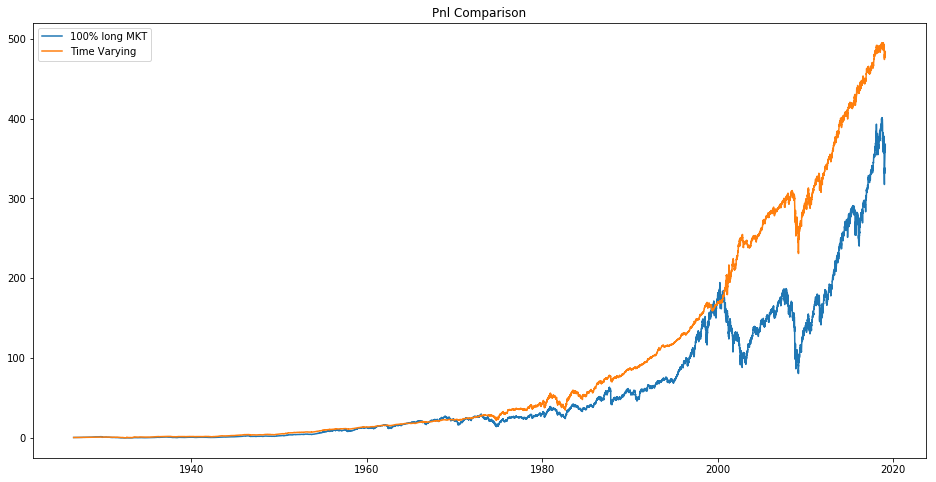

In [20]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')

In [21]:
SR(perf)

0.510950850786477

In [22]:
SR(perf_MKT)

0.24018991744633209

In [23]:
maxDrawDown(perf)

-79.03094956159805

In [24]:
maxDrawDown(perf_MKT)

-114.15000474181704

In [25]:
maxDrawDown(perf)/perf.iloc[-1]

-0.1634730179947802

In [26]:
maxDrawDown(perf_MKT)/perf_MKT.iloc[-1]

-0.3102061239314019

## e) Turnover Smoothing

In [45]:
testingFile = os.path.join('MFE_DAM', 'test_weights.csv')
weights = pd.read_csv(testingFile, parse_dates=[0], index_col=[0])
weights.index = weights.index + BDay(day_lag)
weights['RF'] = 0.

In [46]:
weights.drop(weights.loc[:'1926-7-31'].index, axis=0, inplace=True)

In [47]:
weights.loc[weights.isnull().any(axis=1)]

,MKT,VAL,MOM,QUAL,RF
Date,,,,,


In [48]:
weights

,MKT,VAL,MOM,QUAL,RF
Date,,,,,
1926-08-02,0.661442,0.112853,0.112853,0.112853,0.0
1926-09-01,0.624792,0.125069,0.125069,0.125069,0.0
1926-10-01,0.613540,0.128820,0.128820,0.128820,0.0
1926-11-01,0.627873,0.124042,0.124042,0.124042,0.0
1926-12-01,0.617232,0.127589,0.127589,0.127589,0.0
1927-01-03,0.595806,0.134731,0.134731,0.134731,0.0
1927-02-01,0.585957,0.138014,0.138014,0.138014,0.0
1927-03-01,0.564196,0.145268,0.145268,0.145268,0.0
1927-04-01,0.545512,0.151496,0.151496,0.151496,0.0


In [49]:
weights = weights.ewm(span=10, axis=0).mean()

In [50]:
weights

,MKT,VAL,MOM,QUAL,RF
Date,,,,,
1926-08-02,0.661442,0.112853,0.112853,0.112853,0.0
1926-09-01,0.641284,0.119572,0.119572,0.119572,0.0
1926-10-01,0.630131,0.123290,0.123290,0.123290,0.0
1926-11-01,0.629387,0.123538,0.123538,0.123538,0.0
1926-12-01,0.625898,0.124701,0.124701,0.124701,0.0
1927-01-03,0.618082,0.127306,0.127306,0.127306,0.0
1927-02-01,0.610341,0.129886,0.129886,0.129886,0.0
1927-03-01,0.599843,0.133386,0.133386,0.133386,0.0
1927-04-01,0.588022,0.137326,0.137326,0.137326,0.0


In [51]:
weights = adjustWeights(weights, us_Price)
(shares, turnover) = convertWeights2Shares(weights, us_Price, GMV, Tcost_vec)
shares_daily = df2Daily(shares, us_Price.index)
shares

,MKT,VAL,MOM,QUAL,RF
Date,,,,,
1926-08-02,658592,112839,NaN,NaN,225682
1926-09-01,637269,116144,NaN,NaN,244044
1926-10-01,625597,120478,NaN,NaN,251444
1926-11-01,634071,117204,NaN,NaN,246445
1926-12-01,625689,120180,NaN,NaN,251746
1927-01-03,611387,123087,132168,NaN,129896
1927-02-01,610392,120507,132547,NaN,133345
1927-03-01,591964,124572,140678,NaN,139985
1927-04-01,584183,129867,138563,NaN,144398


In [52]:
turnover

37689885.81248214

In [53]:
perf, nonNanRow = calcPnl(us_Price, shares_daily)
perf_MKT = cumul_perf(us_ret.loc[us_ret.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

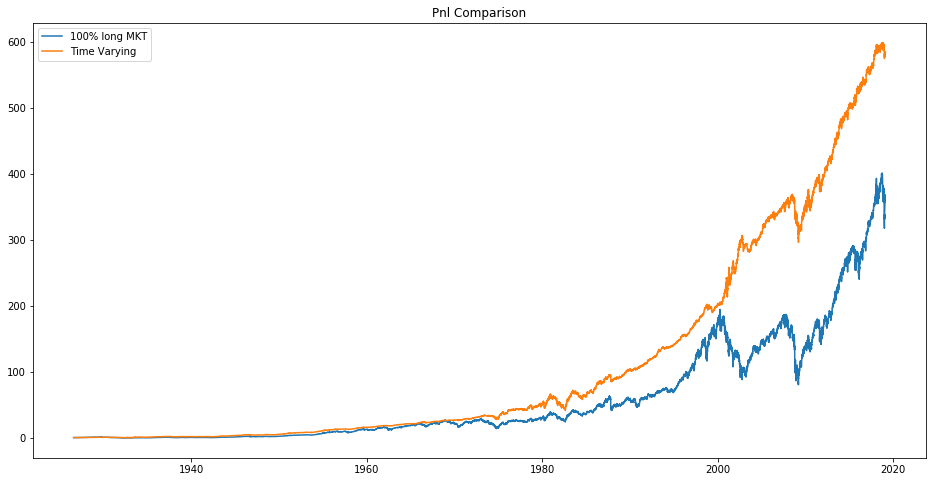

In [54]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')

In [55]:
SR(perf)

0.5506231992852628

In [56]:
SR(perf_MKT)

0.24018991744633209

In [57]:
maxDrawDown(perf)

-72.88489029310921

In [58]:
maxDrawDown(perf_MKT)

-114.15000474181704

In [59]:
maxDrawDown(perf)/perf.iloc[-1]

-0.12496003524278401

In [60]:
maxDrawDown(perf_MKT)/perf_MKT.iloc[-1]

-0.3102061239314019

## f) Garch(1,1) Model

In [19]:
def garchFunc(coeff, y, p, q, flag = False):
    # drop the first one since theres no lagged value for it
    r = y[1:].values
    r_lagged = y.shift(1)[1:].values
    T = len(r)
    resid = r - (coeff[0] + coeff[1]*r_lagged)
    pq = max(p,q)
    # ignore t = pq since its not part of the sum
    resid_t = resid[pq:]
    
    # filter the h
    h_t = []
    # really important how to choose h[0]
    h_t.append(np.mean(resid ** 2))
    h_t = h_t * pq
    # calc the ht
    for i in range(pq,T):
        tmp = coeff[2]
        for j in range((3+q),(3+q+p)):
            tmp += coeff[j]*h_t[i-(j-(2+q))]
        for j in range(3,(3+q)):
            tmp += coeff[j]*( resid[i-(j-2)] ** 2)
        h_t.append(tmp)    
    
    part_1 = -(T-pq)*np.log(2*np.pi)
    part_2 = -np.log(h_t[pq:]).sum()
    part_3 = -np.sum(np.square(resid_t)/h_t[pq:])

    condloglike = 0.5*(part_1 + part_2 + part_3)
    # because we are using a minimize function for maximizing likelihood
    
    if (flag):
        return pd.Series(h_t[0:1]+h_t)
    
    return -condloglike

In [20]:
garch_Train_Yrs = 1

prsn = pd.DataFrame(columns = ['c', 'phi','zeta','alpha','delta'])
p = 1
q = 1
  
x0 = np.asarray([0.001]*(3+q)+[0.9]*p)
bounds = ((None,None),)*2+((0.00000001,None),)*(1+q+p)
rsl11 = op.minimize(garchFunc, x0, args=(us_ret.iloc[0:(252*garch_Train_Yrs),0],p,q), bounds=bounds)
print(rsl11.message)

prsn.loc[0] = rsl11.x
vol_garch = np.sqrt(garchFunc(rsl11.x,us_ret['MKT'],p,q,True)*252)
vol_garch.index = us_ret.index
prsn

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


,c,phi,zeta,alpha,delta
0,0.00032,0.000895,4.680912e-07,0.006067,0.973338


In [21]:
RV_month = us_ret['MKT'].groupby([us_ret.index.year, us_ret.index.month]).std()*np.sqrt(252)
RV_month.index = RV_month.index.map(lambda x: pd.to_datetime('{:d}/{:d}'.format(x[0],x[1]),format='%Y/%m')\
                                    +pd.offsets.MonthEnd())

Text(0.5,1,'Realized Vol of MKT vs. Garch(1,1)')

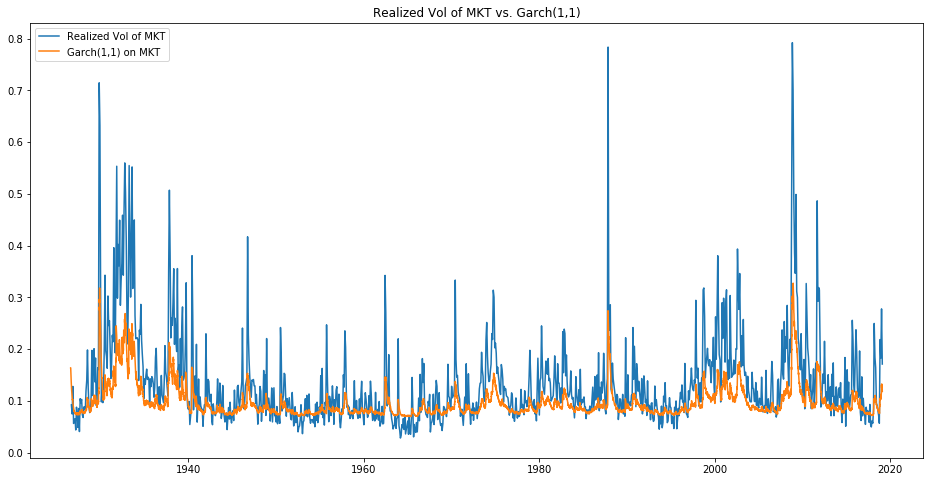

In [22]:
plt.figure('Realized Vol of MKT vs. Garch(1,1)',figsize=(16,8))
plt.clf()
plt.plot(RV_month.index, RV_month.values, label='Realized Vol of MKT')
plt.plot(vol_garch.index, vol_garch.values, label='Garch(1,1) on MKT')
plt.legend(loc = 'best')
plt.title('Realized Vol of MKT vs. Garch(1,1)')

In [23]:
len(RV_month)

1111

In [24]:
len(vol_garch)

25289

In [25]:
RV_month.to_csv('RV_month_US_MKT.csv')

In [26]:
vol_garch.to_csv('vol_garch_US_MKT.csv')

## g) Fixed-weight Portfolios

In [34]:
def fixedWts_BT(weights, df_Price, wtsVec, GMV, Tcost_vec):
    fixedWts = pd.DataFrame(index = weights.index, columns = weights.columns)
    for i in range(0, len(fixedWts)):
        fixedWts.loc[fixedWts.index[i],:] = wtsVec
    
    fixedWts = adjustWeights(fixedWts, df_Price)
    (shares, turnover) = convertWeights2Shares(fixedWts, df_Price, GMV, Tcost_vec)
    shares_daily = df2Daily(shares, df_Price.index)
    perf, nonNanRow = calcPnl(df_Price, shares_daily)
    return (perf, nonNanRow)

In [35]:
inputs = {
    'Pure_Val': np.array([0.,1.,0.,0.,0.]),
    'Pure_Mom': np.array([0.,0.,1.,0.,0.]),
    'Pure_Qual': np.array([0.,0.,0.,1.,0.]),
    'Eq Wts': np.array([0.,1/3,1/3,1/3,0.]),
    'Val Overwt': np.array([0.,0.5,0.25,0.25,0.]),
    'Mom Overwt': np.array([0.,0.25,0.5,0.25,0.]),
    'Qual Overwt': np.array([0.,0.25,0.25,0.5,0.]),
    'Qual Underwt': np.array([0.,0.4,0.4,0.2,0.]),
    'Mom Underwt': np.array([0.,0.4,0.2,0.4,0.]),
    'Val Underwt': np.array([0.,0.2,0.4,0.4,0.]),
}

Text(0.5,1,'Pnl Comparison')

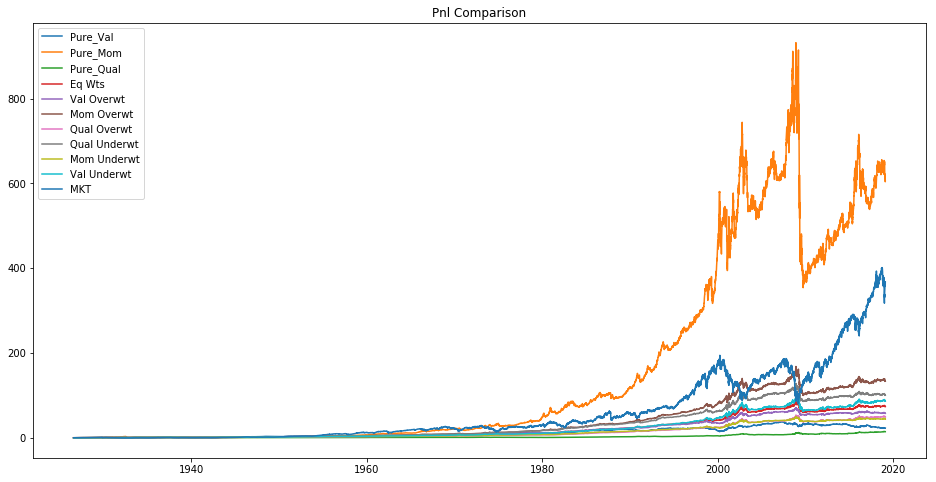

In [36]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
for key, value in inputs.items():
    perf, nonNanRow = fixedWts_BT(weights, us_Price, value, GMV, Tcost_vec)
    plt.plot(perf.index, perf.values, label=key)
perf_MKT = cumul_perf(us_ret.loc[us_ret.index[nonNanRow]:,'MKT'])
plt.plot(perf_MKT.index, perf_MKT.values, label='MKT')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')